In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import ml_utils
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path_data = 'data'
path_train_dir = os.path.join(path_data, 'training')
path_train_label = os.path.join(path_data, 'test_set_images')

PATCH_SIZE = 16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def load_train_set(dir_, data='images', label='groundtruth', ratio=0.8, seed=0):
    np.random.seed(seed)
    # Define path to data
    path_data = os.path.join(dir_, data)
    path_label = os.path.join(dir_, label)
    # Load train data files and sort them according to satImage_xxx.png where xxx is the id number
    files_data = np.array(os.listdir(path_label))
    id_sort = np.argsort([ int(filename[9:12]) for filename in files_data])
    files_data = files_data[id_sort]
    # Check first image to check the size (different for data and label)
    shape_train = mpimg.imread(os.path.join(path_data, files_data[0])).shape
    shape_label = mpimg.imread(os.path.join(path_label, files_data[0])).shape
    # Create empty matrices and load images (data and label)
    x_data = np.zeros((len(files_data),) + shape_train)
    y_label = np.zeros((len(files_data),) + shape_label)
    for i, file in enumerate(files_data):
        x_data[i] = mpimg.imread(os.path.join(path_data, file))
        y_label[i] = np.round(mpimg.imread(os.path.join(path_label, file)))
        
    # Id split for Valisation and test
    ids = np.random.permutation(x_data.shape[0])
    id_train = ids[:int(x_data.shape[0]*ratio)]
    id_valid = ids[int(x_data.shape[0]*ratio):]
    
    return x_data[id_train], y_label[id_train], x_data[id_valid], y_label[id_valid], id_train, id_valid

im_train, lab_train, im_valid, lab_valid, id_train, id_valid = load_train_set(path_train_dir)

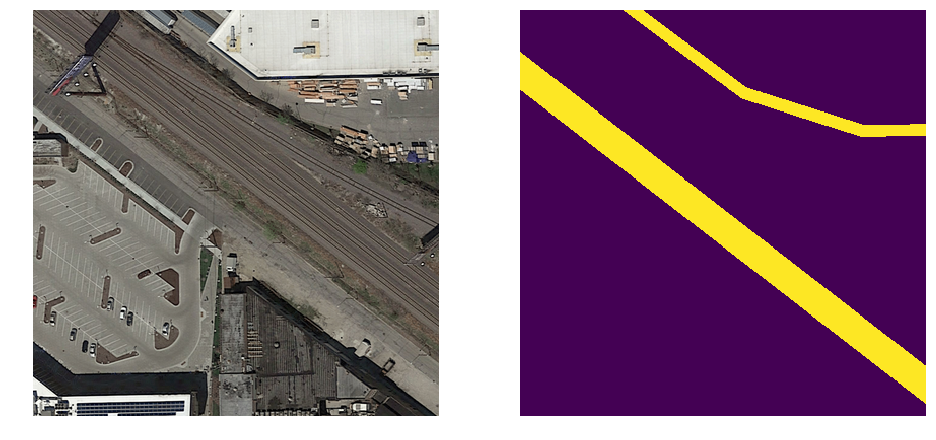

In [13]:
plt.figure(figsize=(16, 8));
plt.subplot(1,2,1); plt.imshow(im_train[0]); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(lab_train[0]); plt.axis("off")
plt.show()

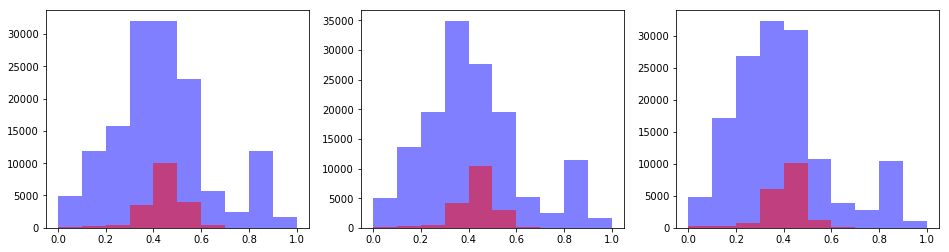

In [14]:
id_road = lab_train[0].flatten()!=0
id_background = lab_train[0].flatten()==0

plt.figure(figsize=(16,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((im_train[0,:,:,i].flatten())[id_background], color='b', alpha=0.5)
    plt.hist((im_train[0,:,:,i].flatten())[id_road], color='r', alpha=0.5)

In [15]:
def normalize_data(data):
    # Data pre-processing, Normalize each image with itself
    n = data.shape[0]
    for i in range(n):
        xx = data[i,:,:]
        xx -= np.mean(xx) # Centering in 0
        xx /= np.linalg.norm(xx) # Normalizing to 1
        data[i] = xx # Affect value
    return data

im_train = normalize_data(im_train)
im_valid = normalize_data(im_valid)

In [16]:
def get_patches(x_data, y_label, patch_size=16):
    # Check if dimension are ok (x_data shapes are mulitples of patch)
    assert(x_data.shape[0] % patch_size == 0 and x_data.shape[1] % patch_size == 0)
    # Create new array that will contain all the patches
    n_patch_h = x_data.shape[0] // patch_size
    n_patch_w = x_data.shape[1] // patch_size
    x_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.zeros((n_patch_h, n_patch_w, patch_size, patch_size))
    # Iterate over all batches
    for i in range(n_patch_h):
        for j in range(n_patch_w):
            x_patches[i, j] = x_data[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            y_patches[i, j] = y_label[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
    # Reshape tu have first dimension as linear feature instead of n_patch_h X n_patch_w
    x_patches = np.reshape(x_patches, (-1, patch_size, patch_size) + x_data.shape[2:])
    y_patches = np.reshape(y_patches, (-1, patch_size, patch_size))
    return x_patches, y_patches

def get_patches_label(y_batch):
    # Create vector of one and zeros (1 is road, 0 is background)
    y_label_unique = np.zeros((y_batch.shape[0]))
    # Take mean value of pixel to estiamte road yes or not
    for i in range(y_batch.shape[0]):
        y_label_unique[i] = np.around(np.mean(y_batch[i]))
    return y_label_unique

def get_patches_all(x_data, y_label, patch_size=16):
    # Ccompute final siz of array of patches
    n_patch_h = x_data.shape[1] // patch_size
    n_patch_w = x_data.shape[2] // patch_size
    x_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size) + x_data.shape[3:])
    y_patches = np.zeros((x_data.shape[0]*n_patch_h*n_patch_w, patch_size, patch_size))
    
    # Iterate over all images to convert them to patches
    for i in range(x_data.shape[0]):
        x_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)], \
        y_patches[i*(n_patch_h*n_patch_w):(i+1)*(n_patch_h*n_patch_w)] = get_patches(x_data[i], y_label[i])
        
    # Compute label for gt (Each patch is either road or background)
    y_batch_label = get_patches_label(y_patches)
    return x_patches, y_patches, y_batch_label

# Convert images to batches (easier for ML task)
x_patches_tr, y_patches_tr, y_patches_lab_tr = get_patches_all(im_train, lab_train, PATCH_SIZE)
x_patches_val, y_patches_val, y_patches_lab_val = get_patches_all(im_valid, lab_valid, PATCH_SIZE)

print('Train:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_tr.shape, y_patches_tr.shape, y_patches_lab_tr.shape))
print('\nValidation:\nx_patches shape: {}, y_patches shape: {}, y_patches_label shape: {}'.format(
    x_patches_val.shape, y_patches_val.shape, y_patches_lab_val.shape))

Train:
x_patches shape: (50000, 16, 16, 3), y_patches shape: (50000, 16, 16), y_patches_label shape: (50000,)

Validation:
x_patches shape: (12500, 16, 16, 3), y_patches shape: (12500, 16, 16), y_patches_label shape: (12500,)


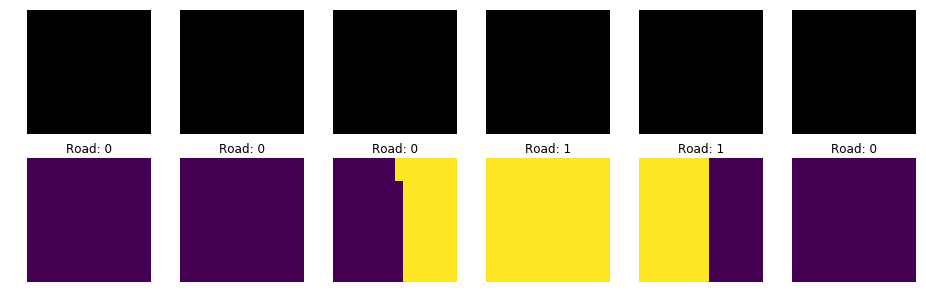

In [17]:
# Do not work beacause normalization, but if removve normalization -> Ok
offset = 3300 
plt.figure(figsize=(16, 5))
for i in range(6):
    plt.subplot(2, 6,i+1)
    plt.imshow(x_patches_tr[offset+i]); plt.axis('off')
    plt.subplot(2, 6, 6+i+1)
    plt.title('Road: {:1.0f}'.format(y_patches_lab_tr[offset+i]))
    plt.imshow(y_patches_tr[offset+i], vmin=0, vmax=1); plt.axis('off')

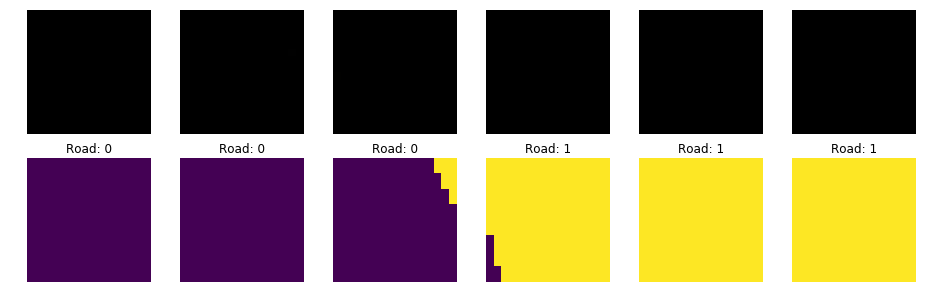

In [18]:
# Do not work beacause normalization, but if removve normalization -> Ok
offset = 12
plt.figure(figsize=(16, 5))
for i in range(6):
    plt.subplot(2, 6,i+1)
    plt.imshow(x_patches_val[offset+i]); plt.axis('off')
    plt.subplot(2, 6, 6+i+1)
    plt.title('Road: {:1.0f}'.format(y_patches_lab_val[offset+i]))
    plt.imshow(y_patches_val[offset+i], vmin=0, vmax=1); plt.axis('off')

In [176]:
def create_features(data):
    # RGB color features
    data_feat = np.std(data, axis=(1,2))
    data_feat = np.concatenate( (data_feat, np.mean(data, axis=(1,2))), axis=1)
    # All color features
    data_feat = np.concatenate( (data_feat, np.expand_dims(np.std(data, axis=(1,2,3)), axis=1)), axis=1)
    data_feat = np.concatenate( (data_feat, np.expand_dims(np.mean(data, axis=(1,2,3)), axis=1)), axis=1)
    return data_feat
    
    
#x_train = np.array([np.std(x_patches_tr, axis=(1,2,3)), np.mean(x_patches_tr, axis=(1,2,3))]).T
#x_valid = np.array([np.std(x_patches_val, axis=(1,2,3)), np.mean(x_patches_val, axis=(1,2,3))]).T
x_train = create_features(x_patches_tr)
x_valid = create_features(x_patches_val)
y_train = y_patches_lab_tr
y_valid = y_patches_lab_val

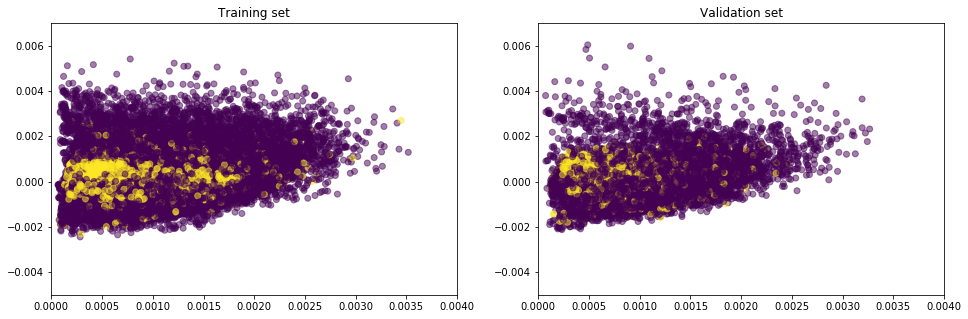

In [177]:
plt.figure(figsize=(16, 5))
plt.subplot(1,2,1)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Training set')
plt.scatter(x_train[:,6], x_train[:,7], c=y_patches_lab_tr, alpha=0.5)
plt.subplot(1,2,2)
plt.xlim([0, 4e-3]); plt.ylim([-5e-3, 7e-3]); plt.title('Validation set')
plt.scatter(x_valid[:,6], x_valid[:,7], c=y_patches_lab_val, alpha=0.5)

In [183]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score
import numpy as np

# model = LogisticRegression(C=1e5, class_weight="balanced")
model = KNeighborsClassifier(n_neighbors=10)
# model = GaussianNB()
# model = SVC(kernel="linear")

model.fit(x_train, y_train)
y_pred_tr = model.predict(x_train)
y_pred = model.predict(x_valid)

In [184]:
print('Accuracy Train: {:.3f}, precision: {:.3f}'.format(
    accuracy_score(y_pred_tr, y_train), precision_score(y_pred_tr, y_train)))
print('Accuracy Validation: {:.3f}, precision: {:.3f}'.format(
    accuracy_score(y_pred, y_valid), precision_score(y_pred, y_valid)))

Accuracy Train: 0.851, precision: 0.388
Accuracy Validation: 0.800, precision: 0.303


In [185]:
def load_image_by_id(_id, dir_, data='images', label='groundtruth'):
    path_data = os.path.join(dir_, data)
    path_label = os.path.join(dir_, label)
    # Load train data files and sort them according to satImage_xxx.png where xxx is the id number
    files_data = np.array(os.listdir(path_label))
    id_sort = np.argsort([ int(filename[9:12]) for filename in files_data])
    files_data = files_data[id_sort]
    file_load = files_data[_id]
    
    im = mpimg.imread(os.path.join(path_data, file_load))
    cgt = np.round(mpimg.imread(os.path.join(path_label, file_load)))
    
    return im, cgt

def patches_to_img(patches, im_shape, patch_size=16):
    n_patch_h = im_shape[0] // patch_size
    n_patch_w = im_shape[1] // patch_size
    
    im_patch = np.zeros(im_shape[:2])
    for i in range(n_patch_h):
        for j in range(n_patch_w):
            is_road = patches[i*n_patch_h+j]
            im_patch[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size] = is_road
    return im_patch

In [188]:
id_try = 0
im, cgt = load_image_by_id(id_valid[id_try], path_train_dir)

cgt_label = patches_to_img(y_valid[id_try*(25*25):(id_try+1)*(25*25)], im.shape)
pred_label = patches_to_img(y_pred[id_try*(25*25):(id_try+1)*(25*25)], im.shape)

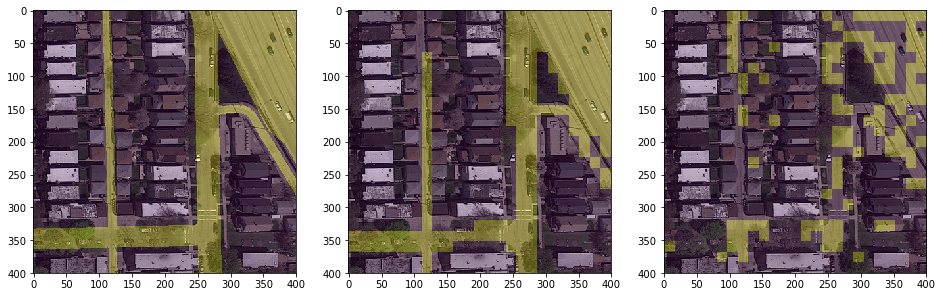

In [189]:
plt.figure(figsize=(16, 8))
plt.subplot(1,3,1)
plt.imshow(im); plt.imshow(cgt, alpha=0.3)
plt.subplot(1,3,2)
plt.imshow(im); plt.imshow(cgt_label, alpha=0.3)
plt.subplot(1,3,3)
plt.imshow(im); plt.imshow(pred_label, alpha=0.3)

Build CNN with very simple architecture as :


$$  kjkj $$ 

In [ ]:
import tensorflow as tf


# Define computational graph (CG)
batch_size=100
K=5
F=10
learning_rate=0.001
reg_par = 1*1e-3 
d1 = x_patches.shape[1]   # data dimensionality
d2 = x_patches.shape[2]   # data dimensionality
nc = 2  # number of classes
ncl = K*K*F
nfc = d1*d2*F

# CNN inputs variables
xin = tf.placeholder(tf.float32,[batch_size, d1, d2]); #print('xin=',xin,xin.get_shape())
y_label = tf.placeholder(tf.float32,[batch_size, nc]);  #print('y_label=',y_label,y_label.get_shape())
d = tf.placeholder(tf.float32);

# CNN learning variables
Wcl = tf.Variable(tf.truncated_normal([K, K, 1, F], stddev=0.1 ));
bcl = tf.Variable(tf.zeros([F])); 
Wfc = tf.Variable(tf.truncated_normal([nfc, nc], stddev=0.1 ));
bfc = tf.Variable(tf.zeros([nc]));

# Layer No 1 --- Convolution
x_2d = tf.reshape(xin, [-1,d1,d2,1]); 
x = tf.nn.conv2d(x_2d, Wcl, strides=[1, 1, 1, 1], padding='SAME') + bcl;
x = tf.nn.relu(x)

# Layer No 2 --- Fully connected
x = tf.nn.dropout(x, d)
x = tf.reshape(x, [batch_size,-1]); 
y = tf.matmul(x, Wfc) + bfc; 
y = tf.nn.softmax(y);

# Loss
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(y), 1))
# L2 Regularization
reg_loss = tf.nn.l2_loss(Wfc) + tf.nn.l2_loss(bfc)
total_loss = cross_entropy + reg_par* reg_loss


# Optimization scheme
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_label,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))